In [1]:
# Import the packages we'll use
import numpy as np
import pandas as pd
import os, glob, csv
from pydub import AudioSegment

## Progress bar
from tqdm.notebook import tqdm
# librosa is a widely-used audio processing library
import librosa
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torchvggish
from torchvggish import vggish_input, vggish, vggish_params, mel_features
from torchvggish import vggish

# for plotting
%matplotlib inline
import matplotlib.pyplot as plt

import math

# for accuracy and confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
# for data normalization
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import confusion_matrix

### Global variables

In [2]:

COMMON_ABSOLUTE_PATH = '/Users/alexandraspyrou/QueenMary/B_Semester/Deep_Learning_audio/Mini-project/common-voice'

TRAIN_AUDIO_PATH_CSV = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-train.csv")
TRAIN_PATH_TO_AUDIOS = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-train")

DEV_AUDIO_PATH_CSV   = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-dev.csv")
DEV_PATH_TO_AUDIOS   = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-dev")

TEST_AUDIO_PATH_CSV  = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-test.csv")
TEST_PATH_TO_AUDIOS  = os.path.expanduser(f"{COMMON_ABSOLUTE_PATH}/cv-valid-test")

SAMPLE_RATE = 48000
NUM_EPOCHS = 100
WEIGHT_AGE = 0.5


### Pre-processing

In [4]:
def pre_process_dataset(df_path:str):
    """
    input:
        df_path: relative path of the csv file to be loaded
    output:
        returns the preprocessed pandas dataframe
        """
    df = pd.read_csv(df_path)
    
    # We remove the NaN data entries to clean the data
    cond1 = df['age'].notna()
    cond2 = df['gender'].notna()
    cond3 = df['gender']!="other"

    df = df[cond1 & cond2 & cond3]
    df.filename = df.filename.apply(lambda x : os.path.splitext(x)[0]+'.wav')

    transf_dict={"age":{"teens":0.0,"twenties":1.0,"thirties":2.0,"fourties":3.0,"fifties":4.0,"sixties":5.0,"seventies":6.0,"eighties":7.0},
                         "gender":{"female":0.0, "male":1.0}}

    return df.replace(transf_dict, )

In [5]:
df_train = pre_process_dataset(TRAIN_AUDIO_PATH_CSV)
df_valid = pre_process_dataset(DEV_AUDIO_PATH_CSV)
df_test = pre_process_dataset(TEST_AUDIO_PATH_CSV)

In [6]:
classes = {'age': df_train.age.unique(), 'gender': df_train.gender.unique()}

In [7]:
# Remember to adjust this function based on the new audio paths!! 
def transform_mp3_to_wav(audio_path, limit=None):
    #Change working directory
    os.chdir(audio_path)

    audio_files = os.listdir()

    # You dont need the number of files in the folder, just iterate over them directly using:
    for idx, file in enumerate(audio_files):
        #spliting the file into the name and the extension
        name, ext = os.path.splitext(file)
        if ext == ".mp3":
            mp3_sound = AudioSegment.from_mp3(file)
            mp3_sound.export("{0}.wav".format(name), format="wav")
        if limit and idx==limit:
            break
        

In [8]:
should_convert = False
if should_convert: 
    transform_mp3_to_wav(DEV_PATH_TO_AUDIOS)
    transform_mp3_to_wav(TEST_PATH_TO_AUDIOS)

### Feature engineering

In [9]:
'''
- Load an example audio file, converts wav samples into MFCC coefficients.
    
- nmfcc = number of components, seconds = chop the audio file
'''
def extract_mfcc(audio_path, filename, n_mfcc, seconds=10, sr = SAMPLE_RATE ):
    audio, sr = librosa.load("%s/%s" % (audio_path, filename), sr=sr, duration = seconds)
    return librosa.feature.mfcc(y=audio, sr=sr,n_mfcc = n_mfcc )

In [10]:
MAX_FILES_TO_LOAD  = 30000      # limit, because loading the whole dataset is very slow
MAX_TIMEFRAMES = 600
N_MFCC = 20
MFCC_SIZE = MAX_TIMEFRAMES * N_MFCC 
GENDER_CATEGORIES = 1
AGE_CATEGORIES = 8

In [11]:
def create_set(df, audio_path, files_to_load = 100):
    data = np.zeros((files_to_load, N_MFCC, MAX_TIMEFRAMES)) # for storing mfccs
    labels = np.zeros((files_to_load,2)) # for storing the annotation
    mfcc_list=[]
    max_num_files = df.shape[0]
    
    with tqdm(total = min(files_to_load, max_num_files)) as progress_bar:
        for idx, row in enumerate(df.itertuples()):
            gender=row.gender
            age_group=row.age
            filename=row.filename
            # Creates the mfccs ad-hoc (Expensive)
            mfcc_feat=extract_mfcc(audio_path, filename, n_mfcc = N_MFCC).T
#             print(f'mfcc features: {mfcc_feat.shape}')
            mfcc_list.append(mfcc_feat.shape[0])
            components, timeframes = mfcc_feat.shape
            # Do a histogram analysis on the optimal number of timesframes to keep. 
            if(timeframes < MAX_TIMEFRAMES):
                mfcc_feat = np.pad(mfcc_feat, ((MAX_TIMEFRAMES-timeframes,1),(0,0)))
            data[idx] = mfcc_feat[:MAX_TIMEFRAMES].T
            labels[idx,0] = gender
            labels[idx,1] = age_group
            idx+=1
            if idx==files_to_load:
                plt.hist(mfcc_list, bins = 20)
                plt.show()
                break
            progress_bar.update(1)
    return (torch.from_numpy(data[:max_num_files]).double(), 
            torch.from_numpy(labels[:max_num_files,0]).double(),
            torch.from_numpy(labels[:max_num_files,1]).double())

### Creating a pickle to store MFCCs

In [12]:
%%time

import pickle

# When running for the first time, you must manually create the folders. Example: !mkdir test_mfcc

PATH_TO_SAVED_TRAIN_MFCC = 'train_mfcc'
PATH_TO_SAVED_DEV_MFCC = 'dev_mfcc'
PATH_TO_SAVED_TEST_MFCC = 'test_mfcc'

rebuild_dataset = False

try:
    print("Loading the files ... ")
    if rebuild_dataset: raise FileNotFoundError
    # If we've already computed these, retrieve them from disk
    train_features, train_gender, train_age = pickle.load(open(f"{PATH_TO_SAVED_TRAIN_MFCC}/train_mfcc.p", "rb"))
    dev_features,  dev_gender, dev_age = pickle.load(open(f"{PATH_TO_SAVED_DEV_MFCC}/validation_mfcc.p", "rb"))
    test_features, test_gender, test_age = pickle.load(open(f"{PATH_TO_SAVED_TEST_MFCC}/testing_mfcc.p", "rb"))
    
except FileNotFoundError:
    print("Files are not present. Creating features ... ")

    train_features, train_gender, train_age = create_set(df_train, TRAIN_PATH_TO_AUDIOS, MAX_FILES_TO_LOAD * 3)
    dev_features,  dev_gender, dev_age = create_set(df_valid, DEV_PATH_TO_AUDIOS, MAX_FILES_TO_LOAD)
    test_features, test_gender, test_age= create_set(df_test, TEST_PATH_TO_AUDIOS, MAX_FILES_TO_LOAD)
    
    pickle.dump((train_features, train_gender, train_age),
                open(f"{PATH_TO_SAVED_TRAIN_MFCC}/train_mfcc.p", "wb"))
    pickle.dump((dev_features, dev_gender, dev_age),
                open(f"{PATH_TO_SAVED_DEV_MFCC}/validation_mfcc.p", "wb"))
    pickle.dump((test_features, test_gender, test_age),
                open(f"{PATH_TO_SAVED_TEST_MFCC}/testing_mfcc.p", "wb"))


print(f"read {train_features.shape[0]} training examples")
print(f"read {dev_features.shape[0]} valid examples")
print(f"read {test_features.shape[0]} test examples")

print(f'data representation {test_features.shape}')

Loading the files ... 
read 72692 training examples
read 1511 valid examples
read 1523 test examples
data representation torch.Size([1523, 20, 600])
CPU times: user 1.19 s, sys: 4.88 s, total: 6.07 s
Wall time: 9.45 s


## Data Analysis - Discover data imbalance

In [13]:
teens, twenties, thirties, fourties, fifties, sixties, seventies, eighties = np.where(train_age == 0)[0].shape[0] / train_age.shape[0], np.where(train_age == 1)[0].shape[0]/train_age.shape[0], np.where(train_age == 2)[0].shape[0] / train_age.shape[0], np.where(train_age == 3)[0].shape[0] / train_age.shape[0], np.where(train_age == 4)[0].shape[0] / train_age.shape[0],np.where(train_age == 5)[0].shape[0] / train_age.shape[0],np.where(train_age == 6)[0].shape[0] / train_age.shape[0],np.where(train_age == 7)[0].shape[0] / train_age.shape[0]
teens, twenties, thirties, fourties, fifties, sixties, seventies, eighties

(0.07303417157321301,
 0.3088235294117647,
 0.25067407692730975,
 0.14954878115886205,
 0.12949155340340066,
 0.06268915423980631,
 0.02245088868101029,
 0.003287844604633247)

In [14]:
zeros, ones = np.where(train_gender == 0)[0].shape[0] / train_gender.shape[0], np.where(train_gender == 1)[0].shape[0]/train_gender.shape[0]
zeros, ones

(0.24898200627304243, 0.7510179937269575)

Counter({1.0: 22449, 2.0: 18222, 3.0: 10871, 4.0: 9413, 0.0: 5309, 5.0: 4557, 6.0: 1632, 7.0: 239})


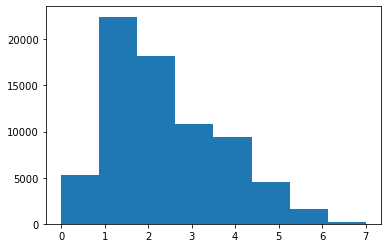

In [15]:
from collections import Counter

ages_spectrum = [age.item() for age in train_age.detach()]

print(Counter(ages_spectrum))
plt.hist(ages_spectrum, bins = 8)
plt.show()

In [2162]:
torch.set_printoptions(precision=3)
np.set_printoptions(precision=3)

### Model architectures

In [16]:
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        # fully connected layers:
        #   5000->50->50->11
        self.fc1 = nn.Linear(MFCC_SIZE, 512)
        self.fc2 = nn.Linear(512, 64) 

        self.fc4 = nn.Linear(64, GENDER_CATEGORIES)
        self.fc5 = nn.Linear(64, AGE_CATEGORIES)
        self.dropout = nn.Dropout(p=0.3)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight) 

        torch.nn.init.xavier_uniform_(self.fc4.weight)
        torch.nn.init.xavier_uniform_(self.fc5.weight)


    def forward(self, x):
        
        x = torch.flatten(x,1,2)
        x = self.dropout(F.leaky_relu(self.fc1(x)))
        x = self.dropout(F.leaky_relu(self.fc2(x))) 

        x_gender = torch.sigmoid(self.fc4(x))
        x_age = self.fc5(x)
        return {'gender': x_gender, 'age':x_age}

class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #2 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=16, kernel_size=(5,50), stride=2, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16, out_channels=8, kernel_size=(4,20), stride=2, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128 * 5 * 4, GENDER_CATEGORIES, bias=True)
        self.linear2 = nn.Linear(128 * 5 * 4, AGE_CATEGORIES, bias=True)


    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.flatten(x)
        
        x_gender = torch.sigmoid(self.linear1(x))
        x_age = self.linear2(x)

        return {'gender': x_gender, 'age': x_age}


class CnnModel(nn.Module):
    """The CNN model"""
    def __init__(self):
        
        super(CnnModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16,
                               kernel_size=(4, 12), bias=False)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=8,
                               kernel_size=(2, 6), bias=False)

        self.conv3 = nn.Conv2d(in_channels=8, out_channels=4,
                               kernel_size=(2, 4), bias=False)
        
        self.fc2 = nn.Linear(60, GENDER_CATEGORIES, bias=True)
        self.fc3 = nn.Linear(60, AGE_CATEGORIES, bias=True)

    def forward(self, x):
        (_, mel_bins, time_len) = x.shape

        x = x.view(-1, 1, mel_bins, time_len )
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,kernel_size=(4,8),padding=(0,4))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,kernel_size=(2, 4),padding=(1,2))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        
        x_gender = torch.sigmoid(self.fc2(x))
        x_age = self.fc3(x)

        return {'gender': x_gender, 'age': x_age}

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

### Training

In [17]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 64
train = TensorDataset(train_features,  train_gender, train_age)
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

dev = TensorDataset(dev_features,  dev_gender, dev_age)
dev_loader = DataLoader(dev, batch_size=BATCH_SIZE*2, shuffle=True)

test= TensorDataset(test_features, test_gender, test_age)
test_loader = DataLoader(test, batch_size=BATCH_SIZE*2, shuffle=True)

In [18]:
# Push model to device. Has to be only done once
from sklearn.metrics import accuracy_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train_model(model, optimizer, num_epochs=10, train_on_age = False, train_on_gender = False, verbose = False):
# Set model to train mode
    model.train() 
    train_loss = []
    valid_loss = []
    valid_acc = []
    train_acc = []
    
    # Criterions for multi-task learning 
    criterion_gender = nn.BCELoss()
    criterion_age = nn.CrossEntropyLoss()
    
    weight_age = WEIGHT_AGE
    weight_gender = 1 - WEIGHT_AGE
    
    results = {'age':   {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []},
              'gender': {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}}
               
    assert train_on_age or train_on_gender
    
    ## Early Stopping params: 
    previous_best = 100
    patience = 4
    epochs_not_improved = 0 
    delta = 5e-5
    
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        epoch_loss_gender, epoch_loss_age = 0,0
        total_num_gender, correct_preds_gender = 0,0 
        total_num_age, correct_preds_age = 0,0 
        total_loss = 0
        for batch_num, data in enumerate(train_loader): 
            
            data_inputs, label_gender, label_age = data[0], data[1], data[2]
            
            data_inputs = data_inputs.to(device).type(torch.FloatTensor)
            label_gender = label_gender.to(device).type(torch.FloatTensor)
            label_age = label_age.to(device).type(torch.LongTensor)

            preds = model(data_inputs)
            preds_gender, preds_age = preds['gender'].squeeze(1), preds['age'].squeeze(1)

               
            #### GENDER STAGE #### 
            
            loss_gender = criterion_gender(preds_gender, label_gender)
            final_preds_gender = (preds_gender >= 0.5).long() # Binarize predictions to 0 and 1   
            
            if train_on_gender and verbose:
                print("Gender mapping prediction from to") 
                for i, (raw_pred, binary_pred) in enumerate(zip(preds_gender, final_preds_gender)):
                    print(raw_pred.item(), '->', binary_pred, 'true_label: ', label_gender[i])
                    if i > 15:
                        break
            correct_preds_gender += (final_preds_gender == label_gender).sum()
            total_num_gender += label_gender.shape[0]
            
            epoch_loss_gender += loss_gender.item() # Summing up all batch losses in an epoch
            
            if train_on_gender: 
                loss = weight_gender * loss_gender
                
                
            #### AGE STAGE #### 
            
            loss_age = criterion_age(preds_age, label_age)
            
            final_preds_age = torch.Tensor(np.argmax(preds_age.detach().numpy(), axis=1))
            
            if train_on_age and verbose:
                print("Age mapping prediction from to:")
                for i, (raw_pred, binary_pred) in enumerate(zip(preds_age, final_preds_age)):
                    print(raw_pred.detach(), '->', binary_pred, 'true_label: ', label_age[i])
                    if i > 15:
                        break
            correct_preds_age += (final_preds_age == label_age).sum()
            total_num_age += label_age.shape[0]
            
            epoch_loss_age += loss_age.item() # Summing up all batch losses in an epoch
            
            if train_on_age: 
                loss = (loss + weight_age * loss_age) if train_on_gender else weight_age *loss_age

            optimizer.zero_grad() 
            
            loss.backward()
            
            ## Step 5: Update the parameters
            optimizer.step() 
            total_loss += loss
        
        # Check if we should stop early
        epoch_total_loss = total_loss / batch_num
        print("train loss:", epoch_total_loss.detach().item())
        
        valid_results = eval_model(model)
                

        # Early stopping
        if previous_best - valid_results['both']['val_loss'] > delta :
            previous_best = valid_results['both']['val_loss']
            epochs_not_improved = 0
        else:
            epochs_not_improved +=1
        
        if epochs_not_improved == patience:
            print(f"Stopping Early")
            break
        
            
        train_acc_gender = correct_preds_gender / total_num_gender
        train_loss_gender = epoch_loss_gender / batch_num
        if train_on_gender:
            print("Gender train loss:", train_loss_gender)
            print("Gender train acc:", train_acc_gender)

        results['gender']['train_acc'].append(train_acc_gender)
        results['gender']['train_loss'].append(train_loss_gender)

        train_acc_age = correct_preds_age / total_num_age
        train_loss_age = epoch_loss_age/batch_num
        if train_on_age:
            print("Age train loss:",train_loss_age)
            print("Age train acc:", train_acc_age)
            
        results['age']['train_acc'].append(train_acc_age)
        results['age']['train_loss'].append(train_loss_age)

        
        results['gender']['val_loss'].append(valid_results['gender']['val_loss'])
        results['gender']['val_acc'].append(valid_results['gender']['val_acc'])
        
        results['age']['val_loss'].append(valid_results['age']['val_loss'])
        results['age']['val_acc'].append(valid_results['age']['val_acc'])

    return results


### Evaluation

In [2191]:
def eval_model(model, which_set = 'dev'):        
    model.eval()

    weight_age = WEIGHT_AGE
    weight_gender = 1 - WEIGHT_AGE
    
    criterion_gender = nn.BCELoss()
    criterion_age = nn.CrossEntropyLoss()

    results = {'age': {}, 'gender' : {}, 'both': {}}
    epoch_loss_total, epoch_loss_gender, epoch_loss_age = 0,0,0
    total_num_gender, correct_preds_gender = 0,0 
    total_num_age, correct_preds_age = 0,0 
    data_loader = dev_loader if which_set == 'dev' else test_loader
    
    # List to append data for confusion matrix
    
    age_predictions = []
    age_labels = []
    
    gender_predictions = []
    gender_labels = []
    
    with torch.no_grad(): # Deactivate gradients for the following code
        total_loss = 0

        for batch_num, data in enumerate(data_loader): 

            data_inputs, label_gender, label_age = data[0], data[1], data[2]

            data_inputs = data_inputs.to(device).type(torch.FloatTensor)
            label_gender = label_gender.to(device).type(torch.FloatTensor)
            label_age = label_age.to(device).type(torch.LongTensor)

            preds = model(data_inputs)
            preds_gender, preds_age = preds['gender'].squeeze(1), preds['age'].squeeze(1)

            #### GENDER STAGE #### 

            loss_gender = criterion_gender(preds_gender, label_gender)

            preds_gender = (preds_gender >= 0.5).long() # Binarize predictions to 0 and 1

            correct_preds_gender += (preds_gender == label_gender).sum()
            total_num_gender += label_gender.shape[0]

            epoch_loss_gender += loss_gender.item()
            
            gender_labels += list([x.item() for x in label_gender.detach()])
            gender_predictions += list([x.item() for x in preds_gender.detach()])
            
            if train_on_gender: 
                loss = weight_gender * loss_gender

            #### AGE STAGE #### 

            loss_age = criterion_age(preds_age, label_age)

            preds_age = torch.Tensor(np.argmax(preds_age.detach().numpy(), axis=1))

            correct_preds_age += (preds_age == label_age).sum()
            total_num_age += label_age.shape[0]

            epoch_loss_age += loss_age.item()
            
            age_labels += list([x.item() for x in label_age.detach()])
            age_predictions += list([x.item() for x in preds_age.detach()])
            
            if train_on_age: 
                loss = (loss + weight_age * loss_age) if train_on_gender else weight_age *loss_age

            total_loss += loss
         
        epoch_total_loss = total_loss / batch_num
        
        val_acc_gender = correct_preds_gender / total_num_gender
        val_loss_gender = epoch_loss_gender/batch_num
        results['gender']['val_acc'] = val_acc_gender
        results['gender']['val_loss']= val_loss_gender
        
        results['gender']['labels'] = gender_labels
        results['gender']['predictions'] = gender_predictions
        
        
        val_acc_age = correct_preds_age / total_num_age
        val_loss_age = epoch_loss_age/batch_num
        results['age']['val_acc'] = val_acc_age
        results['age']['val_loss'] = val_loss_age
        results['age']['labels'] = age_labels
        results['age']['predictions'] = age_predictions
        results['age']['predictions'] = age_predictions
        
        results['both']['val_loss'] = epoch_total_loss


    return results

### Plotting the results

In [2192]:
def plot_acc_loss(results_dict, train_on_gender, train_on_age, title: str):
    if train_on_gender:
        plt.plot(results_dict['gender']['train_loss'], label = f"train_loss gender {max(results_dict['gender']['train_loss'])}")
        plt.plot(results_dict['gender']['val_loss'], label = f"val_loss gender {max(results_dict['gender']['val_loss'])}")

    if train_on_age: 
            plt.plot(results_dict['age']['train_loss'], label = f"train_loss age {max(results_dict['age']['train_loss'])}")
            plt.plot(results_dict['age']['val_loss'], label = f"val_loss age {max(results_dict['age']['val_loss'])}")
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

    if train_on_gender:
        plt.plot(results_dict['gender']['train_acc'], label = f"train_acc gender {max(results_dict['gender']['train_acc'])}")
        plt.plot(results_dict['gender']['val_acc'], label = f"val  acc gender {max(results_dict['gender']['val_acc'])}")

    if train_on_age: 
        plt.plot(results_dict['age']['train_acc'], label = f"train_acc age {max(results_dict['age']['train_acc'])}")
        plt.plot(results_dict['age']['val_acc'], label = f"val acc age {max(results_dict['age']['val_acc'])}")
   
    plt.title(title)
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    
    plt.legend()
    plt.show()

### 1a. Gender - FCNet

In [2130]:
import torch.optim as optim

# create a model instance

net_gender = FCNet()
net_gender.to(device)

optimizer = torch.optim.Adam(net_gender.parameters(), 
                             lr=0.0001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.001)# 0 before)


In [2131]:
train_on_gender = True
train_on_age = False

results_gender = train_model(net_gender,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)

test_results_gender = eval_model(net_gender, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
test_results_gender = eval_model(net_gender, which_set='test')

In [2024]:
f1_gender

0.42658132530120485

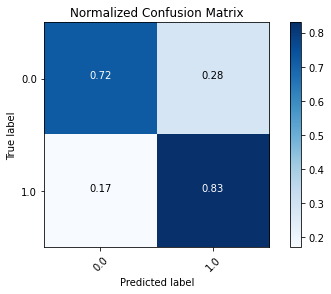

In [2025]:
# F1 score

class_type = 'gender'

f1_gender = f1_score(test_results_gender[class_type]['labels'], test_results_gender[class_type]['predictions'], average='macro')

cm_gender = confusion_matrix(test_results_gender[class_type]['predictions'], test_results_gender[class_type]['labels'])

my_plot_confusion_matrix(cm_gender, classes=classes[class_type], normalize=True)

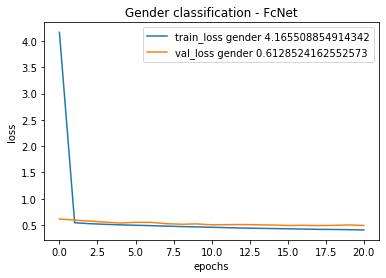

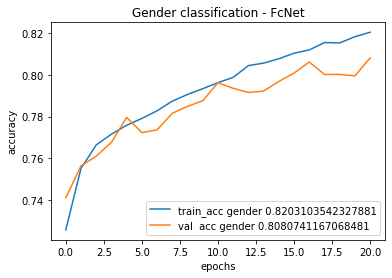

In [2026]:
plot_acc_loss(results_gender, train_on_gender, train_on_age, title = 'Gender classification - FcNet')

In [2037]:
len(test_results_gender[class_type]['predictions'])

1523

In [2044]:
target_names_gender=['0.0', '1.0']

In [2058]:
target_names_age = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0']

In [2146]:
from sklearn.metrics import classification_report
print(classification_report(test_results_gender['gender']['labels'], test_results_gender['gender']['predictions'], target_names=target_names_gender))

              precision    recall  f1-score   support

         0.0       0.72      0.44      0.55       390
         1.0       0.83      0.94      0.88      1133

    accuracy                           0.81      1523
   macro avg       0.77      0.69      0.71      1523
weighted avg       0.80      0.81      0.80      1523



### 1b.Training Age - FCNet

In [2027]:
import torch.optim as optim

# create a model instance

train_cnn = False
net_age = FCNet()
optimizer = torch.optim.Adam(net_age.parameters(), 
                             lr=0.001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0)
net_age.to(device)

train_on_gender = False
train_on_age = True

results_age = train_model(net_age,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)

test_results_age = eval_model(net_age, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1.0481643676757812
Age train loss: 2.0963275052377304
Age train acc: tensor(0.289)
train loss: 0.8268662691116333
Age train loss: 1.6537321813306094
Age train acc: tensor(0.348)
train loss: 0.804042398929596
Age train loss: 1.6080846942994038
Age train acc: tensor(0.367)
train loss: 0.786382257938385
Age train loss: 1.572764254036454
Age train acc: tensor(0.382)
train loss: 0.7711160778999329
Age train loss: 1.542231534966288
Age train acc: tensor(0.398)
train loss: 0.755384087562561
Age train loss: 1.5107692501093322
Age train acc: tensor(0.411)
train loss: 0.7382943034172058
Age train loss: 1.4765869083908687
Age train acc: tensor(0.425)
train loss: 0.7220332622528076
Age train loss: 1.444066515473017
Age train acc: tensor(0.439)
train loss: 0.7100645899772644
Age train loss: 1.4201308438431324
Age train acc: tensor(0.451)
train loss: 0.6994065046310425
Age train loss: 1.3988123662671328
Age train acc: tensor(0.461)
train loss: 0.6875492930412292
Age train loss: 1.3750978

In [2143]:
val_results_age = eval_model(net_age)

preds, label: tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0]) tensor([0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
        1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1

preds, label: tensor([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1]) tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0

0.4588990210782158

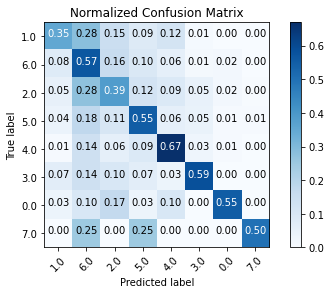

In [2028]:

class_type = 'age'

cm_age = confusion_matrix(test_results_age[class_type]['predictions'], test_results_age[class_type]['labels'])

my_plot_confusion_matrix(cm_age, classes=classes[class_type], normalize=True)

f1_score(test_results_age[class_type]['labels'], test_results_age[class_type]['predictions'], average='macro')


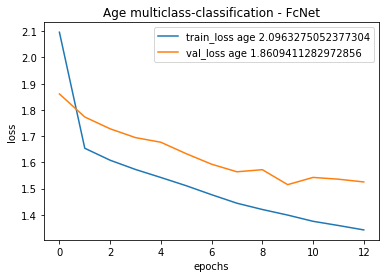

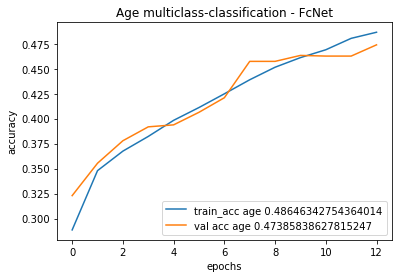

In [2029]:
plot_acc_loss(results_age, train_on_gender, train_on_age, title = 'Age multiclass-classification - FcNet')

In [2144]:
print(classification_report(val_results_age['age']['labels'], val_results_age['age']['predictions'], target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.34      0.31      0.33       112
         1.0       0.60      0.34      0.44       476
         2.0       0.35      0.76      0.48       344
         3.0       0.59      0.34      0.43       240
         4.0       0.66      0.43      0.52       203
         5.0       0.64      0.46      0.54        95
         6.0       0.44      0.51      0.48        37
         7.0       0.40      0.50      0.44         4

    accuracy                           0.46      1511
   macro avg       0.50      0.46      0.46      1511
weighted avg       0.53      0.46      0.46      1511



In [2139]:
print(classification_report(test_results_age['age']['labels'], test_results_age['age']['predictions'], target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.35      0.34      0.35       116
         1.0       0.57      0.35      0.43       456
         2.0       0.39      0.75      0.51       387
         3.0       0.55      0.36      0.44       231
         4.0       0.67      0.45      0.54       205
         5.0       0.59      0.39      0.47        87
         6.0       0.55      0.44      0.49        36
         7.0       0.50      0.40      0.44         5

    accuracy                           0.47      1523
   macro avg       0.52      0.44      0.46      1523
weighted avg       0.52      0.47      0.46      1523



### 1c.Training Multi-task Classification Model using FCNet

In [2030]:
import torch.optim as optim

# create a model instance

train_cnn = False
net_both = FCNet()

optimizer = torch.optim.Adam(net_both.parameters(), 
                             lr=0.0001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0)
net_both.to(device)

train_on_gender = True
train_on_age = True

results_both = train_model(net_both,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)
test_results_both = eval_model(net_both, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1.7639628648757935
Gender train loss: 0.9457671502875862
Gender train acc: tensor(0.657)
Age train loss: 2.5821602442191036
Age train acc: tensor(0.256)
train loss: 1.1254663467407227
Gender train loss: 0.549612769655194
Gender train acc: tensor(0.752)
Age train loss: 1.7013205346557012
Age train acc: tensor(0.324)
train loss: 1.0949524641036987
Gender train loss: 0.531539926471164
Gender train acc: tensor(0.764)
Age train loss: 1.6583645840573416
Age train acc: tensor(0.347)
train loss: 1.074560284614563
Gender train loss: 0.520844309077914
Gender train acc: tensor(0.768)
Age train loss: 1.6282745822410751
Age train acc: tensor(0.360)
train loss: 1.0603374242782593
Gender train loss: 0.5150475509103699
Gender train acc: tensor(0.770)
Age train loss: 1.6056282199952046
Age train acc: tensor(0.368)
train loss: 1.0450695753097534
Gender train loss: 0.5078711886763048
Gender train acc: tensor(0.772)
Age train loss: 1.582268139024138
Age train acc: tensor(0.381)
train loss: 1.0

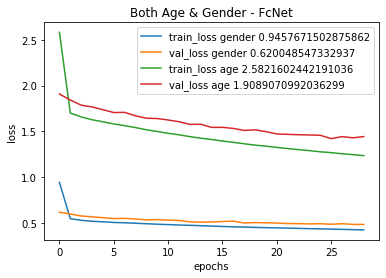

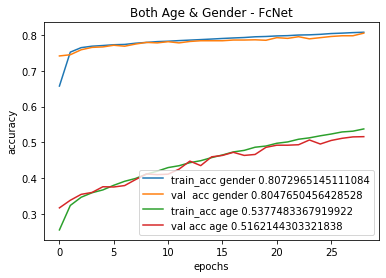

In [2031]:
plot_acc_loss(results_both, train_on_gender, train_on_age, title = 'Both Age & Gender - FcNet')

/var/folders/cv/wvmms0897_l57ws1hqj6rlx00000gn/T/ipykernel_24575/2240696538.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


0.4109362581984879

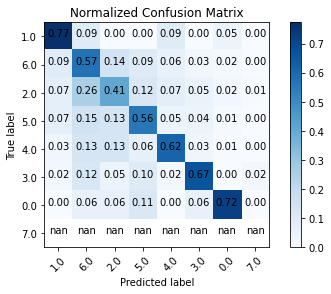

In [2032]:
class_type = 'age'

cm_both = confusion_matrix(test_results_both[class_type]['predictions'], test_results_both[class_type]['labels'])

my_plot_confusion_matrix(cm_both, classes=classes[class_type], normalize=True)

f1_score(test_results_both[class_type]['labels'], test_results_both[class_type]['predictions'], average='macro')

In [2147]:
print(classification_report(test_results_both['age']['labels'], test_results_both['age']['predictions'], target_names= target_names_age))

              precision    recall  f1-score   support

         0.0       0.77      0.15      0.25       116
         1.0       0.57      0.48      0.52       456
         2.0       0.41      0.73      0.52       387
         3.0       0.56      0.42      0.48       231
         4.0       0.62      0.59      0.60       205
         5.0       0.67      0.32      0.43        87
         6.0       0.72      0.36      0.48        36
         7.0       0.00      0.00      0.00         5

    accuracy                           0.51      1523
   macro avg       0.54      0.38      0.41      1523
weighted avg       0.56      0.51      0.50      1523



/Users/alexandraspyrou/opt/anaconda3/envs/uni/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2138]:
print(classification_report(test_results_both['gender']['labels'], test_results_both['gender']['predictions'], target_names= target_names_gender))

              precision    recall  f1-score   support

         0.0       0.84      0.22      0.35       390
         1.0       0.79      0.98      0.87      1133

    accuracy                           0.79      1523
   macro avg       0.81      0.60      0.61      1523
weighted avg       0.80      0.79      0.74      1523



### 2a. Training Gender Classification Model using CNNModel

In [2193]:
class AudioCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=8, kernel_size = 10, stride=2, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=8 , out_channels=4, kernel_size=5, stride=2, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=4 , out_channels=2, kernel_size=2, stride=2, padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten = nn.Flatten()
        
        self.linear1 = nn.Linear(20, GENDER_CATEGORIES, bias=True)
        self.linear2 = nn.Linear(20, AGE_CATEGORIES, bias=True)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(4)
        self.bn3 = nn.BatchNorm2d(2)
        

    def forward(self, input_data):
        x = self.bn1(self.conv1(input_data))
        x = self.bn2(self.conv2(x))
        x = self.bn3(self.conv3(x))
        x = self.flatten(x)
        x_gender = torch.sigmoid(self.linear1(x))
        x_age = self.linear2(x)

        return {'gender': x_gender, 'age': x_age}

In [2194]:
import torch.optim as optim


net_gender = AudioCNN()
net_gender.to(device)

optimizer = torch.optim.Adam(net_gender.parameters(), 
                             lr=0.0001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0.001)# 0 before)


In [2195]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

train = TensorDataset(train_features.unsqueeze(1),  train_gender, train_age)
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)

dev = TensorDataset(dev_features.unsqueeze(1),  dev_gender, dev_age)
dev_loader = DataLoader(dev, batch_size=BATCH_SIZE*2, shuffle=True)

test= TensorDataset(test_features.unsqueeze(1), test_gender, test_age)
test_loader = DataLoader(test, batch_size=BATCH_SIZE*2, shuffle=True)

In [2196]:
train_on_gender = True
train_on_age = False

cnn_results_gender = train_model(net_gender,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)

cnn_test_results_gender = eval_model(net_gender, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.34276893734931946
Gender train loss: 0.6855378801076948
Gender train acc: tensor(0.585)
train loss: 0.2836471498012543
Gender train loss: 0.5672942339323691
Gender train acc: tensor(0.751)
train loss: 0.2780192494392395
Gender train loss: 0.5560384275892233
Gender train acc: tensor(0.751)
train loss: 0.2768167555332184
Gender train loss: 0.5536334998807193
Gender train acc: tensor(0.751)
train loss: 0.2757640779018402
Gender train loss: 0.551528382984027
Gender train acc: tensor(0.751)
train loss: 0.2747562527656555
Gender train loss: 0.5495126521797432
Gender train acc: tensor(0.751)
train loss: 0.2738247215747833
Gender train loss: 0.5476487892052151
Gender train acc: tensor(0.754)
train loss: 0.27314549684524536
Gender train loss: 0.5462906390822406
Gender train acc: tensor(0.761)
train loss: 0.2719714045524597
Gender train loss: 0.5439426631916987
Gender train acc: tensor(0.762)
train loss: 0.27084335684776306
Gender train loss: 0.5416866608128148
Gender train acc: te

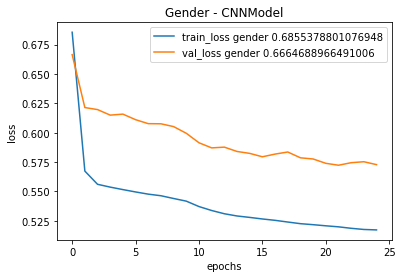

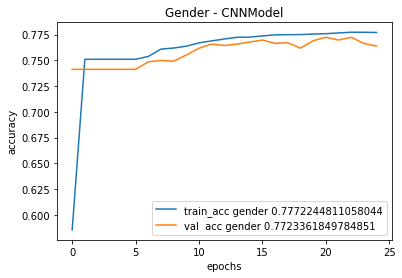

In [2197]:
plot_acc_loss(cnn_results_gender, train_on_gender, train_on_age, title = 'Gender - CNNModel')

0.5563977511345932

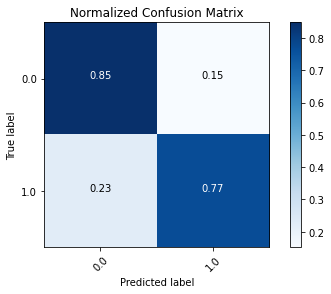

In [2198]:
# F1 score
class_type = 'gender'

cnn_cm_gender = confusion_matrix(cnn_test_results_gender[class_type]['predictions'], cnn_test_results_gender[class_type]['labels'])

my_plot_confusion_matrix(cnn_cm_gender, classes=classes[class_type], normalize=True)

f1_score(cnn_test_results_gender[class_type]['labels'], cnn_test_results_gender[class_type]['predictions'], average='macro')


### 2b. Training Age Classification Model using CNNModel

In [2199]:
import torch.optim as optim

# create a model instance

net_age = AudioCNN()

optimizer = torch.optim.Adam(net_age.parameters(), 
                             lr=0.001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0)
net_age.to(device)

train_on_gender = False
train_on_age = True

cnn_results_age = train_model(net_age,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)

cnn_test_results_age = eval_model(net_age, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 0.8628818988800049
Age train loss: 1.7257629074189107
Age train acc: tensor(0.305)
train loss: 0.8374776244163513
Age train loss: 1.6749558935081381
Age train acc: tensor(0.327)
train loss: 0.8249785900115967
Age train loss: 1.6499571701503535
Age train acc: tensor(0.342)
train loss: 0.8181909918785095
Age train loss: 1.6363824417937696
Age train acc: tensor(0.346)
train loss: 0.8142680525779724
Age train loss: 1.6285360357309753
Age train acc: tensor(0.351)
train loss: 0.8102119565010071
Age train loss: 1.6204235301668948
Age train acc: tensor(0.354)
train loss: 0.8079738616943359
Age train loss: 1.6159487023752692
Age train acc: tensor(0.356)
train loss: 0.8057051301002502
Age train loss: 1.6114099378627829
Age train acc: tensor(0.359)
train loss: 0.8039809465408325
Age train loss: 1.6079624377683397
Age train acc: tensor(0.359)
train loss: 0.8026211857795715
Age train loss: 1.6052434411868124
Age train acc: tensor(0.360)
train loss: 0.801640510559082
Age train loss: 1.60

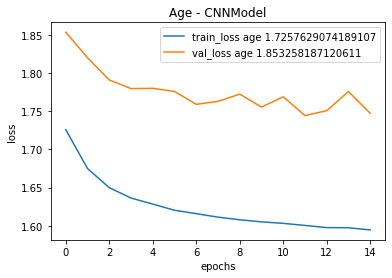

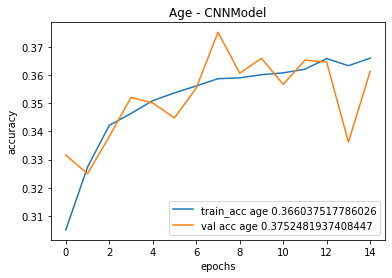

In [2200]:
plot_acc_loss(cnn_results_age, train_on_gender, train_on_age, title = 'Age - CNNModel')

/var/folders/cv/wvmms0897_l57ws1hqj6rlx00000gn/T/ipykernel_24575/2240696538.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


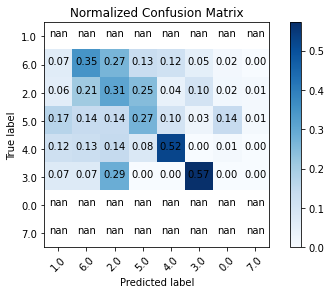

In [2201]:
# F1 score

class_type = 'age'

cnn_cm_gender = confusion_matrix(cnn_test_results_age[class_type]['predictions'], cnn_test_results_age[class_type]['labels'])

my_plot_confusion_matrix(cnn_cm_gender, classes=classes[class_type], normalize=True)

cnn_f1_age = f1_score(cnn_test_results_age[class_type]['labels'], cnn_test_results_age[class_type]['predictions'], average='macro')


### 2c. Training Multi-task Classification Model using CNNModel

In [2202]:
import torch.optim as optim

# create a model instance

train_cnn = True
net_both = FCNet()
if train_cnn:
    net_both = AudioCNN()

optimizer = torch.optim.Adam(net_both.parameters(), 
                             lr=0.0001, betas=(0.9, 0.999), 
                             eps=1e-08, weight_decay=0)
net_both.to(device)

train_on_gender = True
train_on_age = True

cnn_results_both = train_model(net_both,
                      optimizer,
                      train_on_gender = train_on_gender, 
                      train_on_age = train_on_age,
                      num_epochs=NUM_EPOCHS)
cnn_test_results_both = eval_model(net_both, which_set='test')

  0%|          | 0/100 [00:00<?, ?it/s]

train loss: 1.2139147520065308
Gender train loss: 0.5682560084674853
Gender train acc: tensor(0.749)
Age train loss: 1.8595729003393702
Age train acc: tensor(0.292)
train loss: 1.1481208801269531
Gender train loss: 0.5630312542820817
Gender train acc: tensor(0.751)
Age train loss: 1.7332123843583767
Age train acc: tensor(0.308)
train loss: 1.1425870656967163
Gender train loss: 0.5626188219381324
Gender train acc: tensor(0.751)
Age train loss: 1.7225534217473168
Age train acc: tensor(0.309)
train loss: 1.140365719795227
Gender train loss: 0.5628084043574229
Gender train acc: tensor(0.751)
Age train loss: 1.7179234275733848
Age train acc: tensor(0.309)
train loss: 1.1380438804626465
Gender train loss: 0.5629147939745025
Gender train acc: tensor(0.751)
Age train loss: 1.7131712069070286
Age train acc: tensor(0.310)
train loss: 1.1357144117355347
Gender train loss: 0.563312046039472
Gender train acc: tensor(0.751)
Age train loss: 1.70811366982397
Age train acc: tensor(0.312)
train loss: 1.

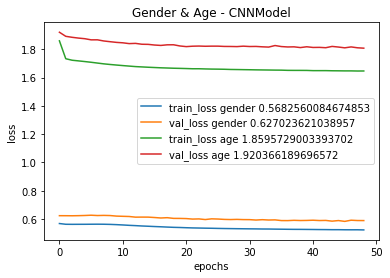

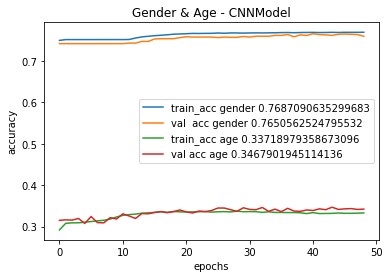

In [2203]:
plot_acc_loss(cnn_results_both, train_on_gender, train_on_age, title = 'Gender & Age - CNNModel')

/var/folders/cv/wvmms0897_l57ws1hqj6rlx00000gn/T/ipykernel_24575/2240696538.py:9: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


0.10341158513539717

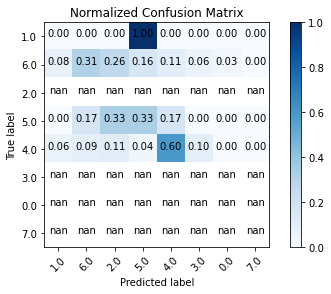

In [2204]:
class_type = 'age'

cnn_cm_both = confusion_matrix(cnn_test_results_both[class_type]['predictions'], cnn_test_results_both[class_type]['labels'])

my_plot_confusion_matrix(cnn_cm_both, classes=classes[class_type], normalize=True)

f1_score(cnn_test_results_both[class_type]['labels'], cnn_test_results_both[class_type]['predictions'], average='macro')

### Confusion matrix

In [ ]:
import itertools
import matplotlib.pyplot as plt



def my_plot_confusion_matrix(cm, classes, normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized Confusion Matrix"
    else:
        title = "Confusion Matrix (without normalization)"
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.title(title)

    thresh = cm.max() / 2.
    fmt = "{:0.2f}" if normalize else "{:d}"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, fmt.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Experimenting with a case study audio clip

In [1737]:
case_example = test_features[44].unsqueeze(0).unsqueeze(0).type(torch.FloatTensor)

In [1739]:
# Storing the results of the CNNModel
cnn_results_dict = net_age(case_example)


In [1740]:
F.softmax(cnn_results_dict['age'])+1

/var/folders/cv/wvmms0897_l57ws1hqj6rlx00000gn/T/ipykernel_24575/520323352.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(cnn_results_dict['age'])+1


tensor([[1.003, 1.010, 1.034, 1.015, 1.937, 1.001, 1.000, 1.000]],
       grad_fn=<AddBackward0>)

In [1747]:
# Storing the results of the FcNet
fc_results_dict = net_both(case_example.squeeze(1))

In [1732]:
df_test.reset_index(inplace= True)

In [1733]:
df_test.query("filename == 'cv-valid-test/sample-000102.wav'")

,index,filename,text,up_votes,down_votes,age,gender,accent,duration
44,102,cv-valid-test/sample-000102.wav,after the dictator's rule of fourty three year...,1,0,4.0,0.0,indian,NaN
